<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>ChatGPT And Friends</h1>
<h1>Word2vec</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

from scipy.spatial import distance

import matplotlib
import matplotlib.pyplot as plt 

from ipywidgets import interact

import os
import gzip

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import datasets

import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


import tqdm as tq
from tqdm.notebook import tqdm
tqdm.pandas()

import networkx as nx

import watermark

%load_ext watermark
%matplotlib inline

We start by printing out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

Compiler    : Clang 15.0.0 (clang-1500.1.0.2.5)
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 1f87e80538ad172ebadf16b8ffe7f1e01f363ed6

tqdm      : 4.66.1
re        : 2.2.1
networkx  : 3.2.1
numpy     : 1.26.4
scipy     : 1.12.0
json      : 2.0.9
matplotlib: 3.8.2
torch     : 2.2.0
pandas    : 2.2.0
watermark : 2.4.3
datasets  : 1.16.1



Load default figure style

In [3]:
plt.style.use('d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Code

In [4]:
dataset = datasets.load_dataset('tweets_hate_speech_detection')

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (/Users/bgoncalves/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/3e953745870454cf8ff15cc48097dbb5ff459596e0a089867c2a29cee63984ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
ss = SnowballStemmer('english')
sw = stopwords.words('english')

def split_tokens(row):                             # STEP
    row['all_tokens'] = [ss.stem(i) for i in       # 5
                     re.split(r" +",               # 3
                     re.sub(r"[^a-z@# ]", "",      # 2
                            row['tweet'].lower())) # 1
                     if (i not in sw) and len(i)]  # 4
    return row

# Determine vocabulary so we can create mapping
dataset = dataset.map(split_tokens)


Parameter 'function'=<function split_tokens at 0x17d28df80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/31962 [00:00<?, ?ex/s]

In [6]:
counts = Counter([i for s in dataset['train']['all_tokens'] for i in s])
counts = {k:v for k, v in counts.items() if v>10} # Filtering
vocab = list(counts.keys())
n_v = len(vocab)
id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}

# Now correct tokens
def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row

dataset = dataset.map(remove_rare_tokens)


  0%|          | 0/31962 [00:00<?, ?ex/s]

In [7]:
def windowizer(row, wsize=3):
    """
    Windowizer function for Word2Vec. Converts sentence to sliding-window
    pairs.
    """
    doc = row['tokens']
    wsize = 3
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]
        window = [i+j for j in
                  range(-wsize, wsize+1, 1)
                  if (i+j>=0) &
                     (i+j<len(doc)) &
                     (j!=0)]

        out+=[(target, tok2id[doc[w]]) for w in window]
    row['moving_window'] = out
    return row

dataset = dataset.map(windowizer)


  0%|          | 0/31962 [00:00<?, ?ex/s]

In [8]:
from utils import *

BATCH_SIZE = 2**14
N_LOADER_PROCS = 10

dataloader = {}
for key in dataset.keys():
    dataloader = {key: DataLoader(Word2VecDataset(
                                    dataset[key], vocab_size=n_v),
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=N_LOADER_PROCS)}


In [9]:
size = 10
input = 3

def one_hot_encode(input, size):
    vec = torch.zeros(size).float()
    vec[input] = 1.0
    return vec

ohe = one_hot_encode(input, size)
linear_layer = nn.Linear(size, 1, bias=False)

# Set edge weights from 0 to 9 for easy reference
with torch.no_grad():
    linear_layer.weight = nn.Parameter(
        torch.arange(10, dtype=torch.float).reshape(linear_layer.weight.shape))

print(linear_layer.weight)
print(linear_layer(ohe))


Parameter containing:
tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]], requires_grad=True)
tensor([3.], grad_fn=<SqueezeBackward4>)


In [10]:
embedding_layer = nn.Embedding(size, 1)

with torch.no_grad():
    embedding_layer.weight = nn.Parameter(
        torch.arange(10, dtype=torch.float
        ).reshape(embedding_layer.weight.shape))

print(embedding_layer.weight)
print(embedding_layer(torch.tensor(input)))


Parameter containing:
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]], requires_grad=True)
tensor([3.], grad_fn=<EmbeddingBackward0>)


In [11]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        # Encode input to lower-dimensional representation
        hidden = self.embed(input)
        # Expand hidden layer to predictions
        logits = self.expand(hidden)
        return logits


In [12]:
# Instantiate the model
EMBED_SIZE = 100 # Quite small, just for the tutorial
model = Word2Vec(n_v, EMBED_SIZE)

# Relevant if you have a GPU:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define training parameters
LR = 3e-4
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [13]:
progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)


  0%|          | 0/530 [00:00<?, ?it/s]

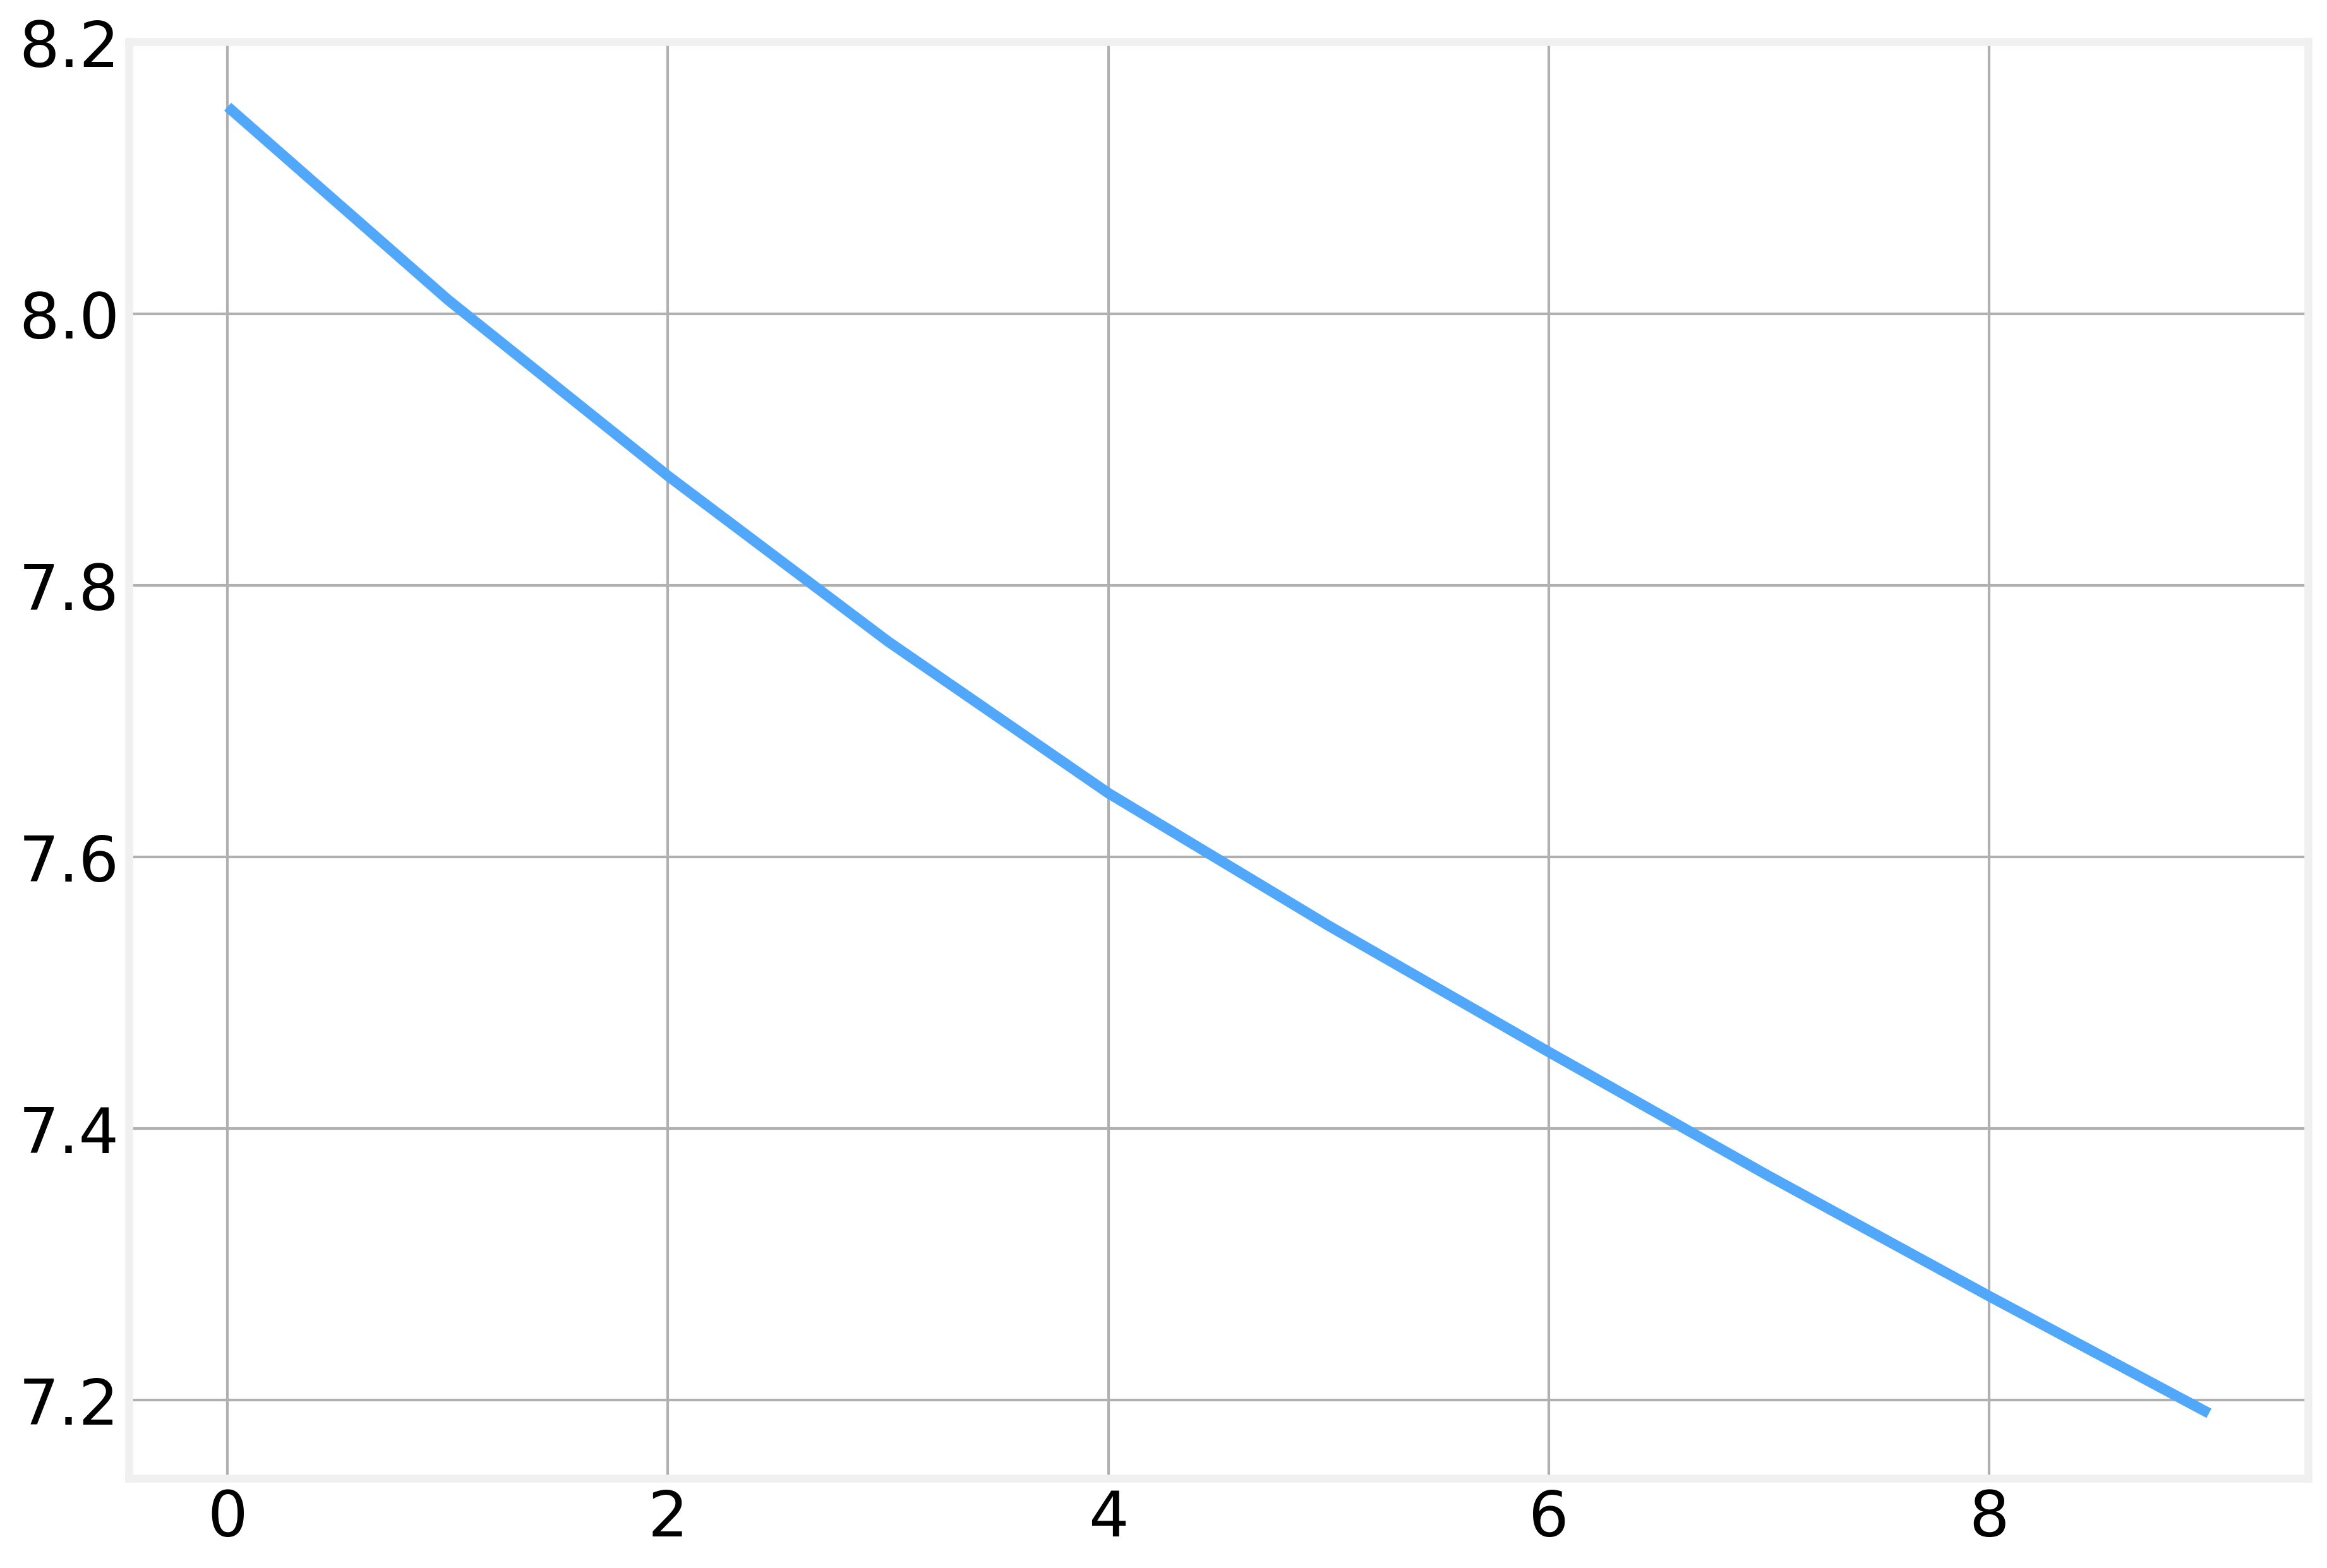

In [14]:
plt.plot(running_loss)

In [15]:
wordvecs = model.expand.weight.cpu().detach().numpy()
tokens = ['good', 'father', 'school', 'hate']

In [16]:
def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")


good ['yeah', 'bong', 'bing', 'everi', 'amp', 'open', 'come', 'first', 'life', 'new'] 

father ['happi', 'dad', 'today', '#fathersday', 'day', 'everi', 'wish', '#father', 'thing', 'read'] 

school ['amp', 'hard', '#smile', 'twitter', 'someon', 'pleas', 'dont', 'everi', 'hope', 'see'] 

hate ['@user', 'get', 'sad', 'watch', 'know', 'world', 'someth', 'today', 'amp', 'love'] 



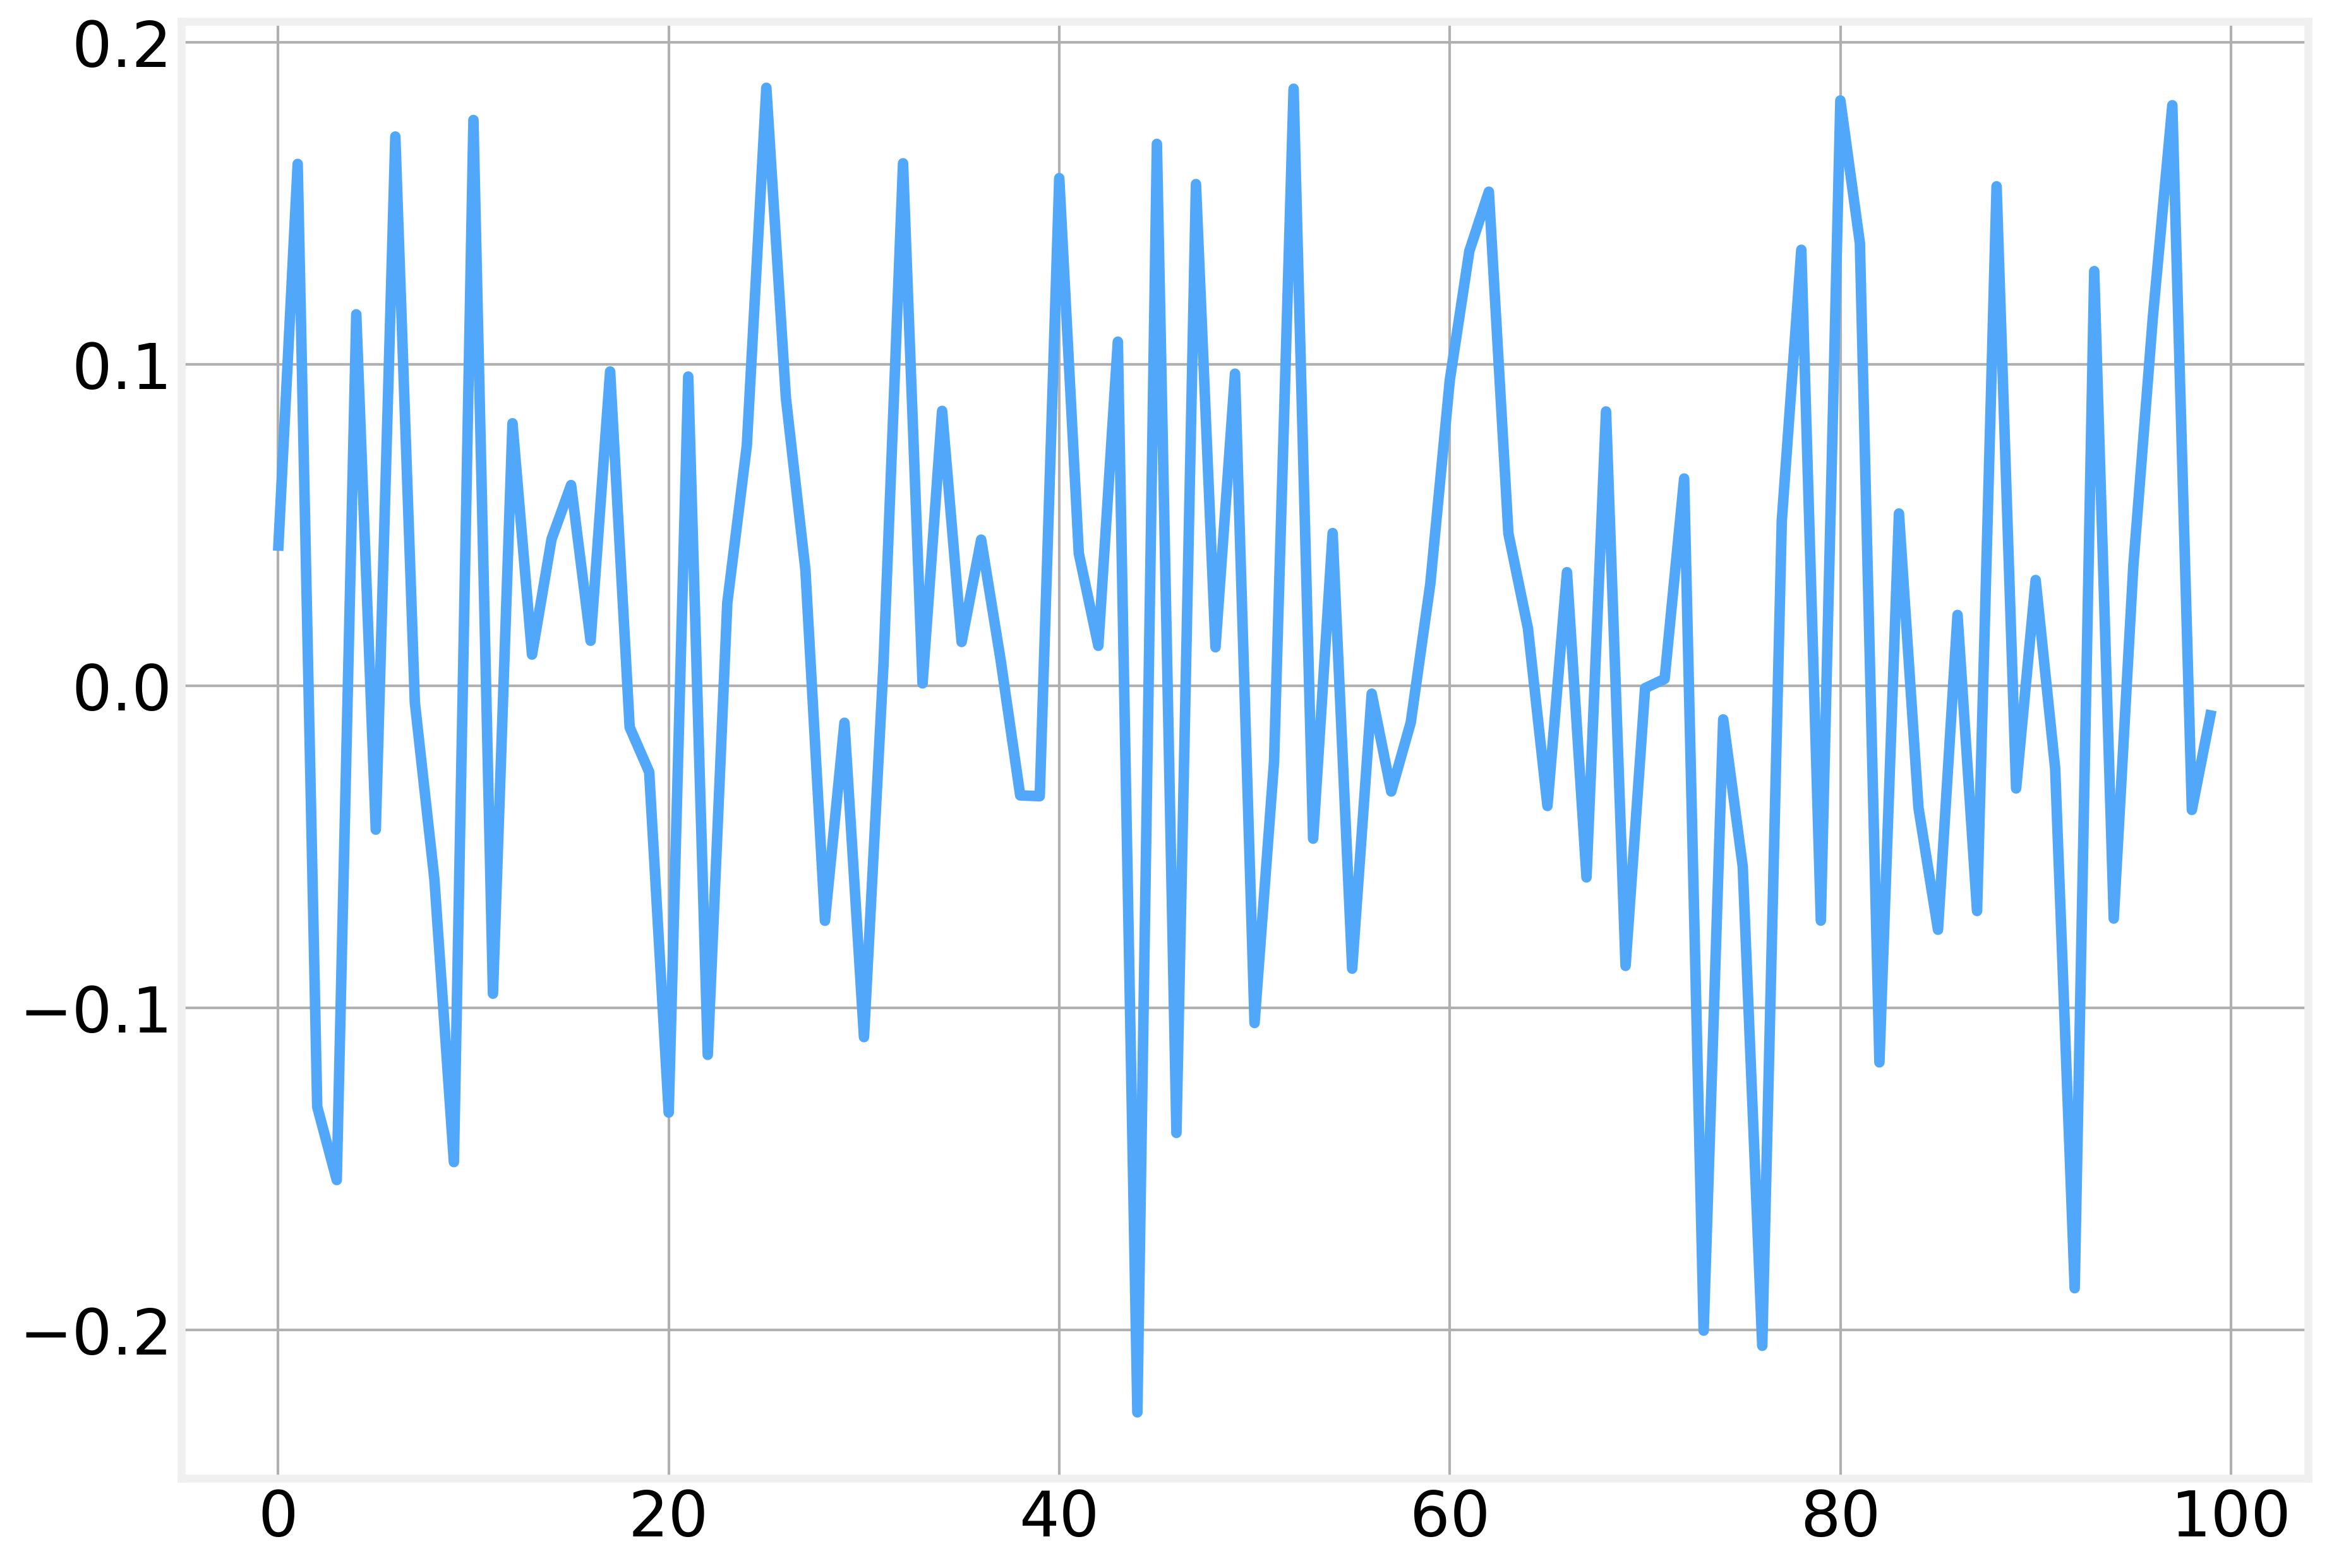

In [17]:
idx = tok2id['father']
plt.plot(wordvecs[idx])

In [18]:
q

NameError: name 'q' is not defined

In [ ]:
EPOCHS = 90
progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)

In [ ]:
wordvecs_100_epochs = model.expand.weight.cpu().detach().numpy()
dmat_100_epochs = get_distance_matrix(wordvecs_100_epochs, 'cosine')
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat_100_epochs)], "\n")

<center>
     <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>